#### Weekly assignment 5
### Solution, part 1
## Inventory dynamics


Consider the following inventory problems in discrete time $t=0,\dots,T$, where possibly $T=\infty$.

The notation is:
- $x(t)\ge 0$ is inventory at period $t$
- $d(t)\ge 0$ is _potentially stochastic_ demand at period $t$
- $s(t)\ge 0$ is the order of new inventory
- $p$ is the profit per one unit of (supplied) good
- $c$ is the fixed cost of ordering any amount of new inventory
- $r$ is the cost of storing one unit of good

The sales in period $t$ are given by $\min\{x(t),d(t)\}$. 
The next period inventory is given by $x(t+1) = \max\{x(t)-d(t),0\} + s(t)$.

The profit in period $t$ is given by

\begin{eqnarray}
\pi(t) & = & p \cdot \text{sales}(t) - r \cdot x(t+1) - c \cdot (\text{order made in period }t) \\
& = & p \min\{x(t),d(t)\} - r \big[ \max\{x(t)-d(t),0\} + s(t) \big] - c \mathbb{1}\{s(t)>0\}
\end{eqnarray}

Assuming all $ s(t) \ge 0$, let $\sigma =  \{s(t)\}_{t=1,\dots}$ denote a feasible inventory policy.
If $d(t)$ is stochastic the policy becomes a function of the period $t$ inventory $x(t)$.

The expected profit maximizing problem is given by

$$
{\max}_{\sigma} \mathbb{E}\Big[ \sum_{t=0}^{\infty} \beta^t \pi(t) \Big],
$$

where $\beta$ is discount factor.

### 1. Write the Bellman equation for the problem

What is important for the inventory decision at time period $t$?
- instanteneous utility (profit) contains $x(t)$ and $d(t)$
- timing: (beginning of period) - current inventory - demand - (choice) order - (end of period)

So, both $x(t)$ and $d(t)$ are takes into account for the new order to be made, which is delivered in the same period, and stored for the storage cost.

So, denoting $d'$ the next period demand, and dropping the time indexes (infinite horizon), the Bellman equation is

$$
V(x,d) = \max_{s \ge 0} \Big\{ p \min\{x,d\} - r \big[ \max\{x-d,0\} + s \big] - c \mathbb{1}\{s>0\} 
+ \beta \mathbb{E}\Big[ V\big( \max\{x-d,0\} + s, d' \big) \Big| x,d,s \Big] \Big\}
$$

The expectation in the Bellman equation is taken over the distribution of the next period demand $d'$, which according to the problem is independent of any other variables (idiosyncratic), thus the conditioning on $(x,d,s)$ can be meaningfully dropped.

$$
V(x,d) = \max_{s \ge 0} \Big\{ p \min\{x,d\} - r \big[ \max\{x-d,0\} + s \big] - c \mathbb{1}\{s>0\} 
+ \beta \mathbb{E}\Big[ V\big( \max\{x-d,0\} + s, d' \big) \Big] \Big\}
$$

$$
V(x,d) = \max_{s \ge 0} \Big\{ p \min\{x,d\} - r \big[ \max\{x-d,0\} + s \big] - c \mathbb{1}\{s>0\} 
+ \beta \int V\big( \max\{x-d,0\} + s, d' \big) dF(d') \Big\}
$$


### 2. Finite horizon deterministic case

Let $T<\infty$. Further, let $d=25$ be known in every period. How does the Bellman equation change?

Write a backwards induction solver for the problem.
Use the following parameters: $(c,p,r,\beta)=(15,2.5,0.2,0.975)$.

In the deterministic case with fixed $d$, it can be simply dropped from the state space, and the Bellman equation can be simplified to

$$
V(x) = \max_{s \ge 0} \big\{ p \min\{x,d\} - r \big[ \max\{x-d,0\} + s \big] - c \mathbb{1}\{s>0\} 
+ \beta \mathbb{E}\Big[ V\big( \max\{x-d,0\} + s \big) \Big] \big\}
$$

In [274]:
import numpy as np
import matplotlib.pyplot as plt

class inventory_model:
    '''Small class to hold model fundamentals and its solution'''
    
    def __init__(self,label='none',max_inventory=10):
        '''Create model with default parameters'''
        self.label=label # label for the model instance
        # default model parameters
        self.c = 3.2
        self.p = 2.5
        self.r = 0.2
        self.β = 0.95
        self.fixed_demand = 4 # for the fixed demand case 
        # grid of inventory (x)
        self.n = max_inventory+1 # number of inventory levels
        self.upper = max_inventory # upper boundary on inventory
        self.x = np.arange(self.n)
        # initial value and policy functions
        self.value = np.zeros(self.n)
        self.policy = np.zeros(self.n)
        
    def __repr__(self):
        '''String representation of the model'''
        return 'Inventory model "%s"\nParamters: c=%1.2f, p=%1.2f, r=%1.2f, β=%1.4f\nMax inventory=%r\nFixed demand=%r\n' \
               %(self.label,self.c,self.p,self.r,self.β,self.upper,self.fixed_demand)

    def sales(self,x,d):
        '''Sales in given period'''
        return np.minimum(x,d)
    
    def remaining(self,x,d):
        '''Inventory remaining after sales in given period'''
        return x - self.sales(x,d)

    def next_x(self,x,d,s):
        '''Next period inventory'''
        return self.remaining(x,d) + s

    def profit(self,x,d,s):
        '''Profit in given period'''
        return self.p * self.sales(x,d) - self.r * self.next_x(x,d,s) - self.c * (s>0)

    def plot(self,axes=None):
        '''Plot of the solution'''
        if axes==None:
            fig1, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(14,6))
            for ax in (ax1,ax2):
                ax.grid(b=True, which='both', color='0.65', linestyle='-')
                ax.set_xlabel('Inventory')
            ax1.set_title('Value function')
            ax2.set_title('Policy function')
            alpha=1 #no transperancy if axes are not given
        else:
            ax1,ax2=axes
            alpha=0.5 #transparancy if axes are given
        #plot
        if self.value.ndim==1:
            ax1.step(self.x,self.value,where='mid',color='brown',alpha=alpha)
            ax2.step(self.x,self.policy,where='mid',color='navy',alpha=alpha)
        else:
            n=self.value.shape[1] #number of lines (for finite horizon)
            alphastep = (1-0.2)/(n+1) #distance to second number equially divided
            for i in range(n):
                ax1.step(self.x,self.value[:,i],where='mid',color='brown',alpha=1-alphastep*i)
                ax2.step(self.x,self.policy[:,i],where='mid',color='navy',alpha=1-alphastep*i)
        if axes==None:
            plt.show()
        return ax1,ax2

# illustration of broadcasting in class functions
model=inventory_model(label='test')
print(model)

s=np.reshape(model.x,(model.n,1))
print('Current inventory\n',model.x)
print('Current sales\n',model.sales(model.x,model.fixed_demand))
print('Current remaining inventory\n',model.remaining(model.x,model.fixed_demand))
print('Current orders\n',s)
print('Next period inventory\n',model.next_x(model.x,model.fixed_demand,s))
print('Current profits\n',model.profit(model.x,model.fixed_demand,s))    

s=np.zeros(model.n)
print('Current profits with zero orders\n',model.profit(model.x,model.fixed_demand,s))

Inventory model "test"
Paramters: c=3.20, p=2.50, r=0.20, β=0.9500
Max inventory=10
Fixed demand=4

Current inventory
 [ 0  1  2  3  4  5  6  7  8  9 10]
Current sales
 [0 1 2 3 4 4 4 4 4 4 4]
Current remaining inventory
 [0 0 0 0 0 1 2 3 4 5 6]
Current orders
 [[ 0]
 [ 1]
 [ 2]
 [ 3]
 [ 4]
 [ 5]
 [ 6]
 [ 7]
 [ 8]
 [ 9]
 [10]]
Next period inventory
 [[ 0  0  0  0  0  1  2  3  4  5  6]
 [ 1  1  1  1  1  2  3  4  5  6  7]
 [ 2  2  2  2  2  3  4  5  6  7  8]
 [ 3  3  3  3  3  4  5  6  7  8  9]
 [ 4  4  4  4  4  5  6  7  8  9 10]
 [ 5  5  5  5  5  6  7  8  9 10 11]
 [ 6  6  6  6  6  7  8  9 10 11 12]
 [ 7  7  7  7  7  8  9 10 11 12 13]
 [ 8  8  8  8  8  9 10 11 12 13 14]
 [ 9  9  9  9  9 10 11 12 13 14 15]
 [10 10 10 10 10 11 12 13 14 15 16]]
Current profits
 [[ 0.   2.5  5.   7.5 10.   9.8  9.6  9.4  9.2  9.   8.8]
 [-3.4 -0.9  1.6  4.1  6.6  6.4  6.2  6.   5.8  5.6  5.4]
 [-3.6 -1.1  1.4  3.9  6.4  6.2  6.   5.8  5.6  5.4  5.2]
 [-3.8 -1.3  1.2  3.7  6.2  6.   5.8  5.6  5.4  5.2  5. ]
 [

Time period 5

[[ 0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   2.5]
 [ 0.   0.   0.   0.   5. ]
 [ 0.   0.   0.   0.   7.5]
 [ 0.   0.   0.   0.  10. ]
 [ 0.   0.   0.   0.   9.8]
 [ 0.   0.   0.   0.   9.6]
 [ 0.   0.   0.   0.   9.4]
 [ 0.   0.   0.   0.   9.2]
 [ 0.   0.   0.   0.   9. ]
 [ 0.   0.   0.   0.   8.8]] 

Time period 4

[[ 0.     0.     0.     5.5    0.   ]
 [ 0.     0.     0.     8.     2.5  ]
 [ 0.     0.     0.    10.5    5.   ]
 [ 0.     0.     0.    13.     7.5  ]
 [ 0.     0.     0.    15.5   10.   ]
 [ 0.     0.     0.    15.5    9.8  ]
 [ 0.     0.     0.    15.5    9.6  ]
 [ 0.     0.     0.    16.525  9.4  ]
 [ 0.     0.     0.    18.7    9.2  ]
 [ 0.     0.     0.    18.31   9.   ]
 [ 0.     0.     0.    17.92   8.8  ]] 

Time period 3

[[ 0.     0.    12.965  5.5    0.   ]
 [ 0.     0.    15.465  8.     2.5  ]
 [ 0.     0.    17.965 10.5    5.   ]
 [ 0.     0.    20.465 13.     7.5  ]
 [ 0.     0.    22.965 15.5   10.   ]
 [ 0.     0.    22.965 15.5    9.

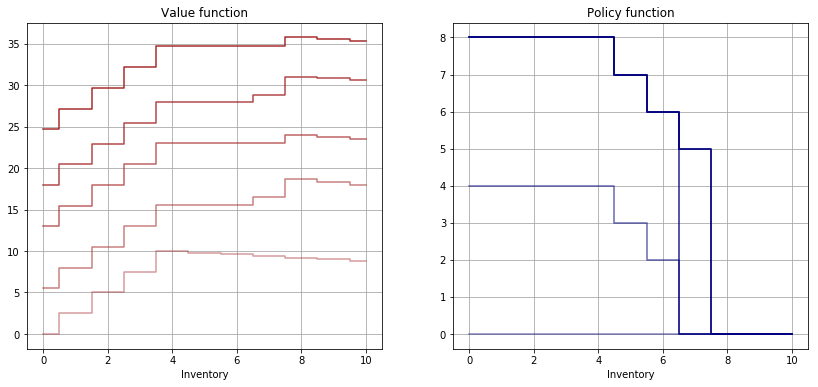

(<matplotlib.axes._subplots.AxesSubplot at 0x12d6fae48>,
 <matplotlib.axes._subplots.AxesSubplot at 0x12d784a90>)

In [285]:
def bellman1(m,j=0):
    '''Bellman equation for the problem with fixed demand
       Inputs: model object
               optional index of next period value function
    '''
    # create the grid of choices (same as x), column-vector
    s = np.reshape(m.x,(m.n,1))
    # compute current period profit (relying on numpy broadcasting to get matrix)
    p = m.profit(m.x,m.fixed_demand,s)
    # indexes for next period value with extrapolation using last value
    i = np.minimum(m.next_x(m.x,m.fixed_demand,s),m.upper)
    # next period value
    if m.value.ndim==1:
        v0=m.value # inifinite horizon case, single value function
    elif m.value.ndim==2:
        v0=m.value[:,j]
    # compute the Bellman maximand
    vm = p + m.β*v0[i]
    # find max and argmax
    v1 = np.amax(vm,axis=0) # maximum in every column
    s1 = np.argmax(vm,axis=0) # index of arg-maximum in every column = order volume
#     s1 = s1 - m.remaining(x,m.fixed_demand) np.maximum(s1 - m.x,0)
    return v1, s1

def solver_backwards_induction(m,T=10,printing=False):
    '''Backwards induction solver for the finite horizon case'''
    # solution is time dependent
    m.value=np.zeros((m.n,T))
    m.policy=np.zeros((m.n,T))
    # main DP loop (from T to 1)
    for t in range(T,0,-1):
        if printing:
            print('Time period %d\n'%t)
        j=t-1 # index for period t
        if t==T:
            # terminal period: zero order is optimal
            m.value[:,j] = m.profit(m.x,m.fixed_demand,np.zeros(m.n))
            m.policy[:,j] = np.zeros(m.n)
        else:
            # all other periods
            m.value[:,j], m.policy[:,j] = bellman1(m,j+1) # next period to Bellman
        if printing:
            print(m.value,'\n')
    # return model with updated value and policy functions
    return m

model = inventory_model(label='illustration')
model=solver_backwards_induction(model,T=5,printing=True)
print('Optimal policy:\n',model.policy)
model.plot()

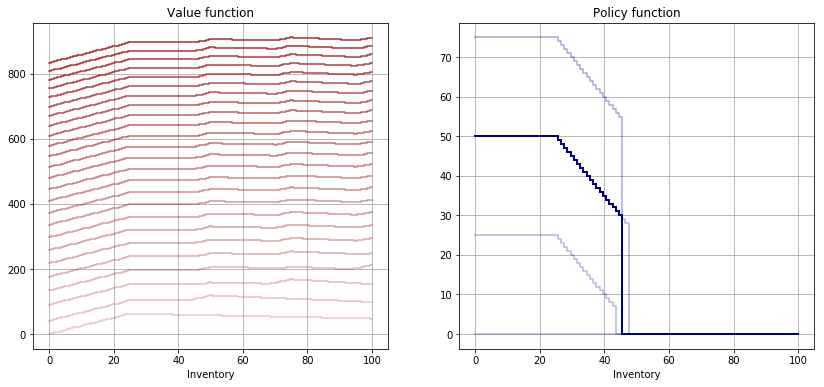

(<matplotlib.axes._subplots.AxesSubplot at 0x12cd28400>,
 <matplotlib.axes._subplots.AxesSubplot at 0x12dad3080>)

In [286]:
# perform the task
mod = inventory_model(label='production',max_inventory=100)
mod.fixed_demand=25
mod.c=15
mod.p=2.5
mod.r=0.2
mod.β=0.975
mod=solver_backwards_induction(mod,T=25)
mod.plot()

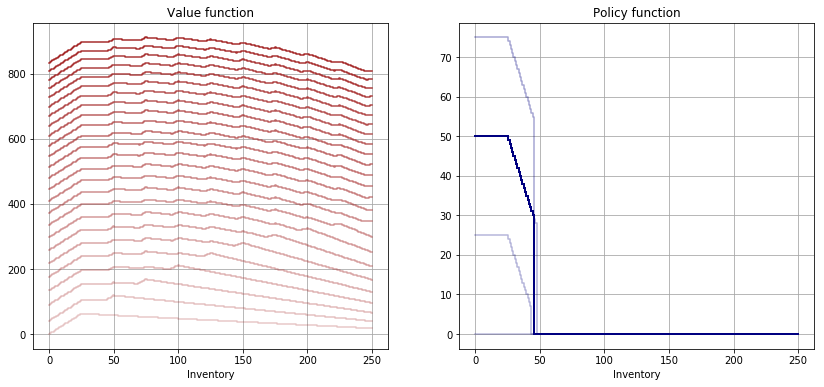

In [287]:
# check how upper boundary affects the result
mod = inventory_model(label='production',max_inventory=250)
mod.fixed_demand=25
mod.c=15
mod.p=2.5
mod.r=0.2
mod.β=0.975
mod=solver_backwards_induction(mod,T=25)
ax=mod.plot()